PROBLEM DESCRIPTION
------------------------------------
The problem we are trying to address is to 'Predict Annual Water Wastage'. The datasaet is water usage in a city from 1885 to 1963. The values are in units of liters per capita per day. The dataset is kept in working directory and named as "water_cons.csv"

ENVIRONMENT
--
The following libraries need to be imported (if not present, need to do a pip install)

In [12]:
import scipy

In [2]:
print('scipy: %s' % scipy.__version__)

scipy: 1.4.1


In [3]:
import numpy, matplotlib, pandas, sklearn, statsmodels

In [4]:
print('numpy: %s' % numpy.__version__ + '\n' + 'matplotlib: %s' % matplotlib.__version__ + '\n' + 'pandas: %s' % pandas.__version__ + '\n' + 'sklearn: %s' % sklearn.__version__ + '\n' + 'statsmodels: %s' % statsmodels.__version__)

numpy: 1.18.4
matplotlib: 3.2.1
pandas: 1.0.3
sklearn: 0.23.1
statsmodels: 0.11.1


TEST HARNESS
--------
1. VALIDATION DATASET: As we are dealing with all historical data, we withold the last 10 years of data from analysis and model selection. Hence the final decade of data will be used to validate the model developed. 
The code below will load the dataset as a Pandas series and split into 2 parts, one for model training (train.csv) and other one for validation (validation.csv)

In [36]:
from pandas import read_csv
series = read_csv('water_cons.csv', header=0, index_col=0)
split_point = len(series) - 10
label_data, validation = series[0:split_point], series[split_point:]
print('Label_Data %d, Validation %d' %(len(label_data), len(validation)))
label_data.to_csv('label_data.csv', index=False, header=False)
validation.to_csv('validation.csv', index=False, header=False)

Label_Data 69, Validation 10


The 2 files are created in the working directory. The specific content of the 2 files are:
a) label_data.csv: The labeled data from year 1885 - 1953 (69 observations)
b) validation.csv: The data from 1954 - 1963 which will be utlised for validation (10 observations)

2. MODEL EVALUATION: The model evaluation considers a) Performance Measure and b) Test Strategy

2.1 Performance Measure - We use RMSE (Root Mean Square Error) to evaluate the predictions. This will provide more weight to the predictions that are grossly incorrect. Any data transforms must be reversed before RSME is computed to make the performance between different measures directly compatible

2.2 Test Strategy - Candidate models will be evaluated using walk-forward validation. This is because a rolling-forecast type model is required from the problem definition. This is where one-step forecasts are needed given all available data.

The walk-forward validation will work as follows:

The first 50% of the dataset will be held back to train the model.
The remaining 50% of the dataset will be iterated to test the model.
For each step in the test dataset:
A model will be trained.
A one-step prediction made and the prediction stored for later evaluation.
The actual observation from the test dataset will be added to the training dataset for the next iteration.
The predictions made during the enumeration of the test dataset will be evaluated and an RMSE score reported.
Given the small size of the data, we will allow a model to be re-trained given all available data prior to each prediction.

We can write the code for the test harness using simple NumPy and Python code.
Firstly, we can split the dataset into train and test sets directly. We’re careful to always convert a loaded dataset to float32 in case the loaded data still has some String or Integer data types.

Next, we can iterate over the time steps in the test dataset. The last line of the above code stores the observations in a list so that it is easy to append a new observation for each iteration.
The prediction made by the model is called 'yhat', which is equivalent to the mathematical predictor of variable y. The predicted value and observation are printed to check for sanity in case we find an issue with the model

PERSISTENCE
--
Here we set a baseline for performance. The benchmark in essence is a template to evauate model using test strategy mentioned above. The baseline prediction for time series forecasting is called naive forecast, or persistence. Essentially this means that the observation from the previous time step is used as the prediction for the observation at the next time step.
The code block is as follows

In [3]:
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
series = read_csv('label_data.csv')
# prepare data for walk-forward validation
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observations
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat,obs))
# report_performance 
mse = mean_squared_error(test,predictions)
rmse = sqrt(mse)
print('RSME: %.3f' % rmse)

>Predicted=503.000, Expected=503
>Predicted=503.000, Expected=515
>Predicted=515.000, Expected=522
>Predicted=522.000, Expected=492
>Predicted=492.000, Expected=503
>Predicted=503.000, Expected=503
>Predicted=503.000, Expected=450
>Predicted=450.000, Expected=432
>Predicted=432.000, Expected=432
>Predicted=432.000, Expected=458
>Predicted=458.000, Expected=462
>Predicted=462.000, Expected=503
>Predicted=503.000, Expected=488
>Predicted=488.000, Expected=466
>Predicted=466.000, Expected=492
>Predicted=492.000, Expected=503
>Predicted=503.000, Expected=515
>Predicted=515.000, Expected=500
>Predicted=500.000, Expected=522
>Predicted=522.000, Expected=575
>Predicted=575.000, Expected=583
>Predicted=583.000, Expected=587
>Predicted=587.000, Expected=628
>Predicted=628.000, Expected=640
>Predicted=640.000, Expected=609
>Predicted=609.000, Expected=606
>Predicted=606.000, Expected=632
>Predicted=632.000, Expected=617
>Predicted=617.000, Expected=613
>Predicted=613.000, Expected=598
>Predicted

Thus using the walk-forward validation we see that RSME of 22 is achieved. This means that the model was off by 22 litres per capita per day for each predicted value. We now have a baseline prediction method and performance. We will now start the exploratory analysis with the data.

DATA ANALYSIS
-------
In the exploratory data analysis, we will use summary statistics and various plots to understand the nature of data and the prediction problem

**1. Summary Statistics** <br>
The following will provide a quick view of the limits of the observed values. We print the statistics for the time series data

In [17]:
from pandas import read_csv
series = read_csv('label_data.csv')
print(series.describe())

              356
count   68.000000
mean   502.602941
std     72.296888
min    344.000000
25%    458.000000
50%    496.000000
75%    540.750000
max    662.000000


The observations are: The mean of the data is around 502, which we might consider level in our series. Also the standard deviation and percentiles suggest a reasonable spread around the mean

**2. Line Plot**

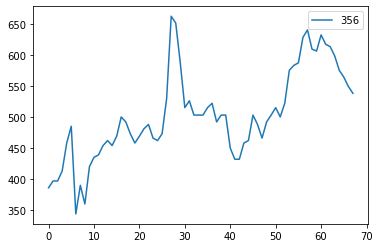

In [21]:
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('label_data.csv')
series.plot()
pyplot.show()

The x-axis are actually years and read it in steps of 10 starting from 1890.
The observations from the above plot are follow: <br>
a) There is an increasing trend in water usage over time <br>
b) There do not appear to be any obvious outliers although be see some large fluctuations <br>
c) There is a downward trend for the last few years of the series <br>
There might be some benefit in explicitly modeling the trend component and removing it. We can also explore using 'differencing with one level or two levels' in order to make the time series stationary

**3. Density Plot** <br>
Reviewing plots of density of observations can provide further insights into the data structure. We do a simple histogram and density plot without any temporal structures

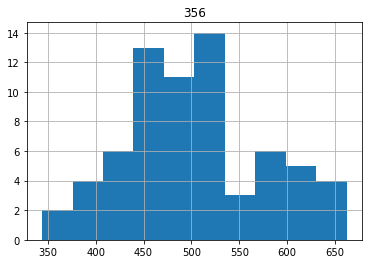

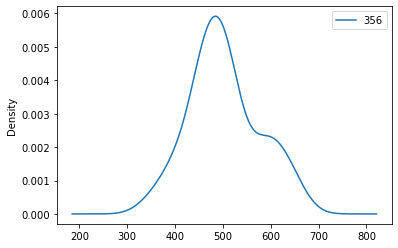

In [25]:
from pandas import read_csv
from matplotlib import pyplot as plt
series = read_csv('label_data.csv')
#pyplot.figure(1)
#pyplot.subplot(211)
series.hist()
#pyplot.subplot(212)
series.plot(kind='kde')
#print(series.hist())
pyplot.show()

Some observations based on the above plots are: <br>
a) The distribution is not Gaussian (normal), but is pretty close <br>
b) The distribution has a long right tail. This may mean that the distribution might be double Gaussian or exponential

**4. Box Plots** <br>
We group the water consumption data into decades and try to see the pattern over decades. We can expect to see some trend (increasing mean  or median)

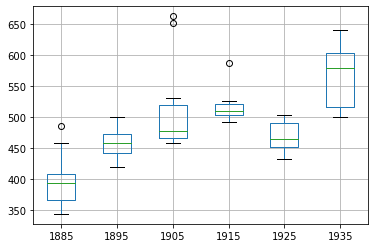

In [58]:
from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
import datetime
import pandas as pd
series = read_csv('water_cons.csv',header=0)
series['Year'] = pd.to_datetime(series['Year'])
groups = series[(series['Year'] >= '12-31-1885') & (series['Year'] <= '12-31-1944')].groupby(Grouper(key='Year',freq='10AS'))
decades = DataFrame()
for name, group in groups['Water']:
    decades[name.year] = group.values
decades.boxplot()
pyplot.show()

Based on the above plot we see that: <br>
a) The median value of each year (green line) show a non-linear increasing trend <br>
b) The middle 50% of the data shown some vairability <br>
c) There maybe some outliers in some decades as indicated by the circle points, which cross the box and whisker plots <br>
d) The 2nd to last decade seem to have lower consumption

ARIMA MODELS
---
We would develop **Autoregressive Integrated Moving Average** or **ARIMA** models to tackle this problem. The modeling approach would use both manual and automatic configuration of the ARIMA model. We also investigate the residual errors of the chosen model. So we can categorize the approach in 3 steps - <br>
1. Manually configure the ARIMA <br>
2. Automatically configure the ARIMA <br>
3. Review the Residual Errors generated by each model

**1. Manually Configure ARIMA** <br>
The ARIMA(p,d,q) model needs 3 parameters when we configure it manually. Analysis of time series data also assumes that we are working with stationary time series. This time series is likely non-stationary. To make it stationary, we would be first differencing the series and further use a statistical test to confirm that the result is stationary. The code below creates a stationary version of TS and saves it to 'stationary.csv'. <br>
**Notes**: *A* **'Stationary' time series** *is one whose properties do not depend on the time at which the series is observed. Hence times series with trends, or with seasonality are not stationary. A 'white noise' series is stationary (it does not matter when you observe, it should look much the same at any point in time). A stationary time series will have no predictable patterns in the long run. Time plots will show these to be roughly horizontal, with constant variance.* <br>
**Differencing:** *One way to make non-stationary time series stationary is to compute the differences between consecutive operations. This is known as differencing. Logarithmic transformations can also help stabilising the variance of time series. Differencing can help stabilize the mean of a time series by removing the changes in the level of a time series and therefore reducing (or eliminating) trend and seasonality.* <br>
The ACF plot can also be used for identifying non-stationary time series. For a stationary time series, the ACF will drop to zero relatively quickly, which the ACF of a non-stationary data will decrease slowly.

ADF Statistic: -6.055566
p-value: 0.000000
Critical Values:
	1%: -3.535
	5%: -2.907
	10%: -2.591


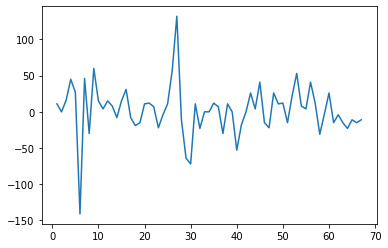

In [69]:
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot
import pandas as pd

# Function to create a difference
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i-1]
        diff.append(value)
    return pd.Series(diff)

series = read_csv('label_data.csv')
X = series.values
X = X.astype('float32')
# Difference Data
stationary = difference(X)
stationary.index = series.index[1:]
# Check is Stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Plot the differenced data by casting the data as integer
stationary = stationary.astype('int64')
stationary.plot()
pyplot.show()
# Save
stationary.to_csv('stationary.csv', index=False, header=False)

We check whether the differenced series is stationary. We do so by running the augmented **'Dickey-Fuller'** test and check for statistical significance of the test. <br>
The results show the test statistic value of -6.055566 is smaller that the critical value at 1% (99% confidence levels) i.e. -3.535. This suggests that we can reject the null hypothesis with significance level of less than 1%. Rejecting the NULL Hypothesis means that the process means that the process has no unit root. This further implies that the time series is stationary and does not have time dependent structure. <br>
**Note:** *The augmented Dickey-Fuller test a.k.a ADF tests the NULL hypothesis: "A unit root is present in a time series sample". This is the means to test that the time series is stationary after 1st differencing. In probability theory and statistics, a unit root is a feature of some stochastic processes (such as random walks) that can cause problems in statistical inference involving time series models. A linear stochastic process has a unit root, if 1 is a root of the process's characteristic equation. Such a process is non-stationary but does not always have a trend. <br>
The augmented Dickey–Fuller (ADF) statistic, used in the test, is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.* <br>

The above result suggests that 1 level of differencing is required. Hence the value of ***d-parameter*** should be at least 1. The difference plot also suggests that the increasing trend has been removed.

The next step is to select the lag values for Auto Regression (AR) and Moving Average (MA) parameters, p and q respectively. We can do this by reviewing the ***Autocorelation Function (ACF)*** and ***Partial Autocorelation Function (PACF)*** plots. The code below creates the ACF and PACF plots for the series.

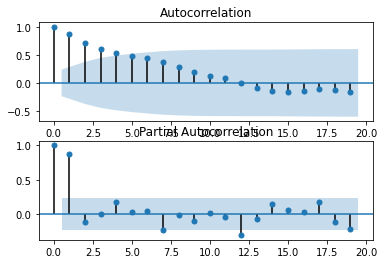

In [77]:
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
series = read_csv('label_data.csv')
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, ax=pyplot.gca())
pyplot.show()

The ACF shows no significant lags. The PACF also does not show any significant lag. Thus a  good starting point for values of p and q is 0. <br>
Thus a quick analysis suggests an ARIMA(0,1,0) on the raw data may be a good starting point. This is in fact a persistence model. The complete code is listed below.

In [87]:
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
# Load data
series = read_csv('label_data.csv')
# Prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# Walk-Forward Validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # Predict
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # Observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# Report Performance
mse = mean_squared_error(test, predictions)
rsme = sqrt(mse)
print('RSME: %.3f' % rsme)

>Predicted=506.545, Expected=503
>Predicted=506.441, Expected=515
>Predicted=518.686, Expected=522
>Predicted=525.778, Expected=492
>Predicted=494.865, Expected=503
>Predicted=506.079, Expected=503
>Predicted=506.000, Expected=450
>Predicted=451.600, Expected=432
>Predicted=433.122, Expected=432
>Predicted=433.095, Expected=458
>Predicted=459.674, Expected=462
>Predicted=463.727, Expected=503
>Predicted=505.600, Expected=488
>Predicted=490.217, Expected=466
>Predicted=467.702, Expected=492
>Predicted=494.208, Expected=503
>Predicted=505.388, Expected=515
>Predicted=517.580, Expected=500
>Predicted=502.235, Expected=522
>Predicted=524.615, Expected=575
>Predicted=578.566, Expected=583
>Predicted=586.648, Expected=587
>Predicted=590.655, Expected=628
>Predicted=632.321, Expected=640
>Predicted=644.456, Expected=609
>Predicted=612.845, Expected=606
>Predicted=609.729, Expected=632
>Predicted=636.100, Expected=617
>Predicted=620.787, Expected=613
>Predicted=616.661, Expected=598
>Predicted

When we execute this example, we get RSME of 22.577, which is slightly higher than the persistence model created earlier. This maybe because of the ARIMA implementation, such as an automatic trend constant that is calculated and added.

**2. Grid Search ARIMA Hyperparameters (Automatic Configuration of ARIMA)** <br>
The ACF and PACF plots suggest that we cannot build a better model on the given dataset. To confirm our analysis, we can can grid search a suite of ARIMA hyperparameters and ensure that no models perform better based on RSME value. <br>
We search for values of (p,d,q) combinations. We will skip those that fail to converge. Based on RSME, we will find the combination that results in best performance. We will use a grid search to explore all possible combinations in a subset of integer values. <br>
Specifically, we will search using a combination of the following parameters: <br>
- *p*: 0 to 4
- *d*: 0 to 2
- *q*: 0 to 4 <br>
This will result in (5 * 3 * 5) petential runs of the test harness, which will take some time to execute. We will disable the automatic addition of a trend constant from the model by setting the *'trend'* argument to *'nc'* for no constant when calling fit(). <br>
The test harness including the grid search version is given below:

In [12]:
import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # Prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X)*0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # Make predictions
    predictions = list()
    for t in range(len(test)):     
        model = ARIMA(history, order=arima_order)
        # model_fit = model.fit(disp=0)
        model_fit = model.fit(trend ='nc', disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # Calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rsme = sqrt(mse)
    return rsme

# Evaluate combinations of p, d and q for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                #print(order)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA %s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
# Load dataset
series = read_csv('label_data.csv')
# Evaluate parameters
p_values = range(0,5)
d_values = range(0,2)
q_values = range(0,5)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA (0, 0, 1) RMSE=278.707
ARIMA (0, 0, 2) RMSE=168.027
ARIMA (0, 0, 3) RMSE=94.934
ARIMA (0, 0, 4) RMSE=74.461
ARIMA (0, 1, 1) RMSE=22.241
ARIMA (0, 1, 2) RMSE=22.641
ARIMA (0, 1, 3) RMSE=25.033
ARIMA (0, 1, 4) RMSE=25.225
ARIMA (1, 0, 0) RMSE=22.203
ARIMA (1, 1, 0) RMSE=22.253
ARIMA (2, 0, 0) RMSE=22.066
ARIMA (2, 1, 0) RMSE=22.062
ARIMA (3, 0, 0) RMSE=22.285
ARIMA (3, 1, 0) RMSE=24.373
ARIMA (3, 1, 1) RMSE=25.511
ARIMA (4, 0, 0) RMSE=24.577
ARIMA (4, 1, 0) RMSE=24.793
ARIMA (4, 1, 1) RMSE=25.462
ARIMA (4, 1, 2) RMSE=26.715
Best ARIMA(2, 1, 0) RMSE=22.062


The results show that the best configuration was achieved for **ARIMA(2,1,0)** with RSME of 22.062. This is slightly lower than the persistence model (RSME = 22.577), which was configured manually. They however, may or may not be significantly different. <br>
We will use ARIMA(2,1,0) as our model going forward based on the performance statistic value.

**3. Review Residual Errors** <br>
The final check on the model is to review the residual forecast errors. Ideally the distribution of residual errors should be Gaussian with 0 mean. We will check using summary statistics and plots for ARIMA(2,1,0) model. The code below computes and summarizes the residual forecast errors.

               0
count  34.000000
mean    1.079139
std    22.366475
min   -52.104758
25%   -16.187762
50%    -0.622212
75%    12.013779
max    51.384141


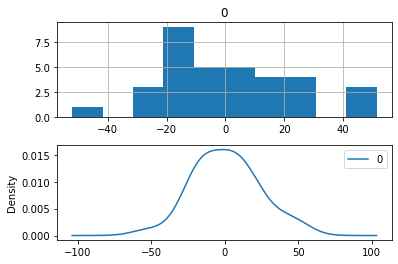

In [15]:
from pandas import read_csv
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from matplotlib import pyplot
# Load Data
series = read_csv('label_data.csv')
# Prepare Data
X = series.values
X = X.astype('float32')
train_size = int(len(X)* 0.50)
train, test = X[0:train_size], X[train_size:]
# Walk-Forward Validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # Predict
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # Observation
    obs = test[i]
    history.append(obs)
# Errors
residuals = [test[i] - predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

We see that the distribution has a right shift and the mean is non-zero at 1.079139. This is an indication that the predictions might be biased. The Gaussian-like distribution suggests a longer right tail, which might provide evidence that a power transformation may be worth exploring. We could use this information to bias-correct the predictions by adding the mean residual error of 1.079139 to each forecast made. <br>
The code below performs this bias-correction.

RSME: 22.035
                  0
count  3.400000e+01
mean   5.173203e-08
std    2.236648e+01
min   -5.318390e+01
25%   -1.726690e+01
50%   -1.701351e+00
75%    1.093464e+01
max    5.030500e+01


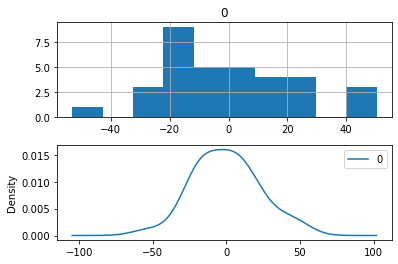

In [17]:
from pandas import read_csv
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from matplotlib import pyplot
# Load Data
series = read_csv('label_data.csv')
# Prepare Data
X = series.values
X = X.astype('float32')
train_size = int(len(X)* 0.50)
train, test = X[0:train_size], X[train_size:]
# Walk-Forward Validation
history = [x for x in train]
predictions = list()
bias = 1.079139
for i in range(len(test)):
    # Predict
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = bias + model_fit.forecast()[0]
    predictions.append(yhat)
    # Observation
    obs = test[i]
    history.append(obs)
# Report Performance
mse = mean_squared_error(test, predictions)
rsme = sqrt(mse)
print('RSME: %.3f' % rsme)
# Summarize Residual Errors
residuals = [test[i] - predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# Plot Residual Errors
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

The performance of model (with the introduction of bias) slightly improves the performance from 22.062 to 22.035. However, the summary of forecast residual errors show that the mean has moved to a value very close to zero. Also, the density plots show a slight shift towards zero.

MODEL VALIDATION 
----


After the models have been developed, we would still need to validate and finalize it. It would include the following steps: <br>
a) Finalize the Model: Save the trained model <br>
b) Make Prediction: Load the above model and make a prediction <br>
c) Validate Model: Validate the predicted data

**1. Finalize Model** <br>
This invloves fitting the ARIMA(2,1,0) model on the entire dataset. Once fit, we save the model for future use. In our case the bias alongwith the whole fit object is saved to the file.

In [18]:
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox
import numpy

def __getnewargs__(self):
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# Load Data
series = read_csv('label_data.csv')
# Prepare Data
X = series.values
X = X.astype('float32')
# Fit Model
model = ARIMA(X, order=(2,1,0))
model_fit = model.fit(trend='nc', disp=0)
# Bias Constant, could be calculated from in-sample mean residual
bias = 1.079139
# Save Model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

Once we execute the above code, we see 2 local files are created: <br>
- ***model.pkl*** This file is the ARIMA result object from the call to ARIMA.fit(). This includes the coefficients and all other internal data returned while we fit the model <br>
- ***model_bias.npy*** The bias value is stored in a one-row, one-column NumPy array

**2. Make Prediction** <br>
We will load the model and make a single forecast. We simply restore the saved model and bias and call the *forecast()* function. The following lines of codes do exactly the above function:

In [19]:
from statsmodels.tsa.arima_model import ARIMAResults
import numpy
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
yhat = bias + float(model_fit.forecast()[0])
print('Predicted: %.3f' % yhat)

Predicted: 540.052


If we look at the first row of the validation dataset, we see its 568. Hence the predicted value of 540 is in the right ballpark.

**3. Validate Model** <br>
We will use the Validation dataset that we had kept aside for testing purposes. The validation can be performed in 2 ways: <br>
- Load the model and we forecast for the next 10 years. The forecast beyond the first one or two years will start to degrade.
- Load the model and use it in a rolling-forecast manner i.e. updating the transform and model for each time step. This is the preferred method in order to achieve the best performance. We step over the lead times in validation dataset and take the observations as an update to the history

>Predicted=540.052, Expected=575
Predicted=578.736, Expected=579
Predicted=576.370, Expected=587
Predicted=588.015, Expected=602
Predicted=602.935, Expected=594
Predicted=593.249, Expected=587
Predicted=588.588, Expected=587
Predicted=588.784, Expected=625
Predicted=627.695, Expected=613
RMSE: 18.794


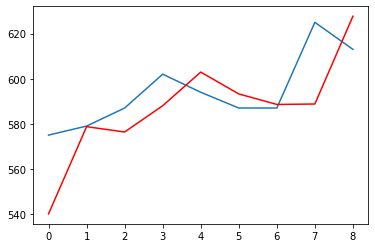

In [20]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

# Load and Prepare Datasets
dataset = read_csv('label_data.csv')
X = dataset.values.astype('float32')
history = [x for x in X]
validation = read_csv('validation.csv')
y = validation.values.astype('float32')
# Load Model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# Make the 1st Prediction
predictions = list()
yhat = bias + float(model_fit.forecast()[0])
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))

# Rolling Forecasts
for i in range(1, len(y)):
    # Predict
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = bias + float(model_fit.forecast()[0])
    predictions.append(yhat)
    # Observation
    obs = y[i]
    history.append(obs)
    print('Predicted=%.3f, Expected=%3.f' % (yhat, obs))

# Report Performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()

The final RMSE is 18.794 litres per capita per day. The above plot shows the predicted values as compared to the validation dataset. The forecast does have the characteristics of a persistence forecast.